In [11]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import os

In [12]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
CHANNELS = 3
EPOCH = 50

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/breast-cancer-data/augmented_data',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 1966 files belonging to 4 classes.


In [14]:
def get_dataset_partitions_tf(ds, train_split = 0.80, val_split =0.1 , test_split =0.1,shuffle = True ,shuffle_size = 10000 ):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds , val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size  =AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size  =AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [19]:
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras import layers, models

base_model=EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(IMAGE_SIZE,IMAGE_SIZE,3)
)

base_model.trainable = False

In [20]:
initial_learning_rate = 0.001
dropout_rate = 0.5
weight_decay = 0.0001
patience = 5
factor = 0.5

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model3 = models.Sequential([
    base_model,
    resize_and_rescale,
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.Flatten(),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.BatchNormalization(), 
    layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay)),
    layers.Dense(n_classes, activation='softmax')

])

model3.build(input_shape = input_shape)

In [22]:
model3.compile(optimizer = 'adam',loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
#checkpoint to save best model per epoch
model_filepath = "/content/drive/MyDrive/model/model3v2/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(
    filepath = model_filepath,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=10,
    verbose=1
)

callbacks_list = [checkpoint, early_stopping]

In [24]:
import time

# Record the start time
start_time = time.time()

In [25]:
history3 = model3.fit(
    train_ds,
    validation_data = val_ds,
    epochs =50,
    callbacks=[early_stopping]
)

Epoch 1/50


2023-12-24 05:46:50.633761: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetv2-s/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


98/98 [==============================] - 89s 461ms/step - loss: 1.6262 - accuracy: 0.3065 - val_loss: 1.4171 - val_accuracy: 0.4167
Epoch 2/50
98/98 [==============================] - 27s 275ms/step - loss: 1.3571 - accuracy: 0.4681 - val_loss: 1.2921 - val_accuracy: 0.5052
Epoch 3/50
98/98 [==============================] - 27s 276ms/step - loss: 1.0810 - accuracy: 0.6264 - val_loss: 1.0897 - val_accuracy: 0.6042
Epoch 4/50
98/98 [==============================] - 27s 276ms/step - loss: 0.9878 - accuracy: 0.6673 - val_loss: 0.7695 - val_accuracy: 0.7500
Epoch 5/50
98/98 [==============================] - 27s 277ms/step - loss: 0.9150 - accuracy: 0.7241 - val_loss: 0.6994 - val_accuracy: 0.8073
Epoch 6/50
98/98 [==============================] - 27s 276ms/step - loss: 0.8252 - accuracy: 0.7631 - val_loss: 0.6350 - val_accuracy: 0.8385
Epoch 7/50
98/98 [==============================] - 27s 277ms/step - loss: 0.7602 - accuracy: 0.7778 - val_loss: 0.7917 - val_accuracy: 0.7708
Epoch 8/50

In [26]:
end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

# Print the elapsed time
print(f"Elapsed time: {elapsed_time} seconds")

Elapsed time: 684.3661653995514 seconds


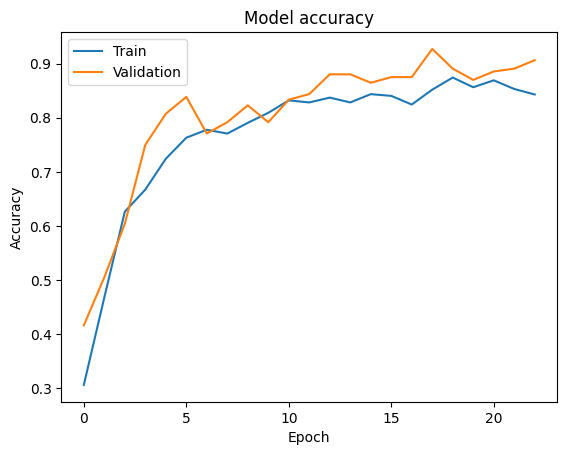

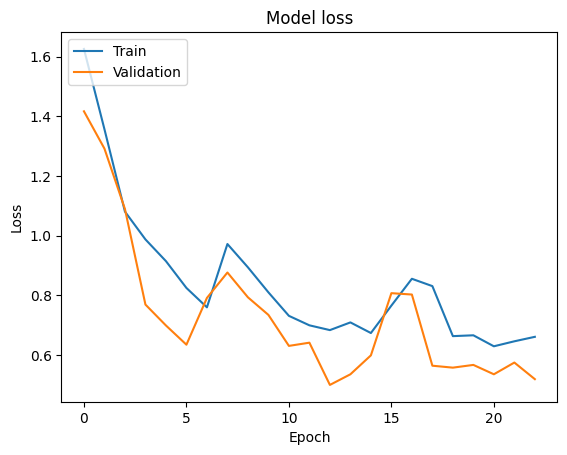

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [28]:
class_names = dataset.class_names
class_names

['Benign', 'InSitu', 'Invasive', 'Normal']

In [30]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming class_names is a list containing the names of your classes
class_names = class_names

# Get predictions on the test set
predictions = model3.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the test dataset
true_labels_ds = test_ds.map(lambda x, y: y)
true_labels = np.concatenate(list(true_labels_ds.as_numpy_iterator()))

# Print classification report with class names
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print(report)


13/13 [==============================] - 1s 120ms/step
              precision    recall  f1-score   support

      Benign       0.88      0.85      0.86        33
      InSitu       0.94      0.89      0.91        66
    Invasive       0.88      0.98      0.93        52
      Normal       0.98      0.95      0.96        57

    accuracy                           0.92       208
   macro avg       0.92      0.92      0.92       208
weighted avg       0.92      0.92      0.92       208

